## Make plots of SEDs for different system parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
from uncertainties import ufloat

from smbh_corona.constants import *
from smbh_corona.thermalsyn import *
from smbh_corona.corona_sed import t_ff, calc_gmax_cool, calc_gmax_conf
from smbh_corona.diffuse_emission import RJ_dust, pl_emission

from smbh_corona.plot_utils import nice_fonts  # Import the nice_fonts settings
from smbh_corona.plot_utils import plot_bands  # Import the nice_fonts settings

matplotlib.rcParams.update(nice_fonts)

### First make an example plot

In [2]:
# System parameters
tau_T = 0.25  # Opacity
r_c = 200.0  # R_c/R_g
M = 2e7 * M_sun  # BH mass
R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius
n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
T = 2e9  # Corona temperature in K
kT = k_B * T  # Corona temperature in keV
theta_e = kT / mec2  # Normalized temperature
t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
eps_B = 1.0  # eps_B = U_mag/U_th
d = 10e6 * pc  # source distance
dil = 4 * pi * d**2
z = 0.01

U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
U_mag = eps_B * U_th
B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

print(f"{kT / keV = :.1e}")
print(f"{t_dyn = :.1e}")
print(f"{B = :.1e}")

# NT electrons
p = 2.7  # Spectral index
delta = 0.03  # U_NT,e/U_th,e
eta_g = 100  # related with D(E) (higher eta_g, lower E_max)

# Maximum energy
gmax_cool = calc_gmax_cool(eta_g, r_c, B)
gmax_conf = calc_gmax_conf(R_c, B)
gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
nuc_max = 4.22e6 * B * gmax_nt**2  # Maximum critical frequency of synchrotron photons

print(f"{gmax_cool = :.2e}")
print(f"{gmax_conf = :.2e}")
print(f"{nuc_max = :.2e}")

kT / keV = 1.7e+02
t_dyn = 1.1e+05
B = 9.2e+01
gmax_cool = 4.69e+04
gmax_conf = 3.24e+13
nuc_max = 8.55e+17


In [3]:
nu_min, nu_max = 5e9, 1e14
nu = np.geomspace(nu_min, nu_max, 300)
nu_obs = nu / (1 + z)

Lnu = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
Lnu_corr = [
    Lnu[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))
]  # Apply correction of the SED at high nu
S_nu = [L / dil / mJy for L in Lnu_corr]

# Some other functions to guide the eye
L_2 = Lnu[1] * 0.9 * np.power(nu / nu[1], 2)
L_52 = Lnu[1] * 3 * np.power(nu / nu[1], 5 / 2)
L_p = Lnu[-1] * 1 * np.power(nu / nu[-1], (-p + 1) / 2)
L_cool = Lnu[-1] * 1.2 * np.power(nu / nu[-1], (-p) / 2)

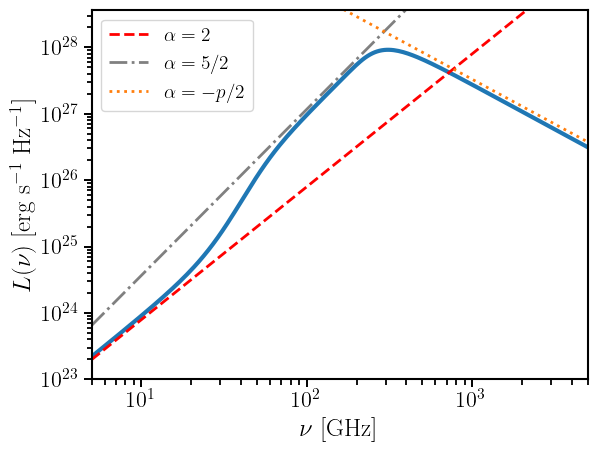

In [4]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$L(\nu)$ [erg s$^{-1}$ Hz$^{-1}$]")
ymin, ymax = Lnu[-1], 2 * max(Lnu)
plt.xlim(nu_min / 1e9, 5e12 / 1e9)
plt.ylim(1e23, 2 * ymax)

plt.plot(nu / 1e9, Lnu, ls="-", linewidth=3, label="", zorder=1)
plt.plot(
    nu / 1e9, L_2, ls="--", linewidth=2, label=r"$\alpha=2$", color="red", zorder=1
)
plt.plot(
    nu / 1e9, L_52, ls="-.", linewidth=2, label=r"$\alpha=5/2$", color="grey", zorder=1
)
plt.plot(nu / 1e9, L_cool, ls=":", linewidth=2, label=r"$\alpha=-p/2$", zorder=1)

ax.loglog()

ax.legend(loc="best")
plt.show()
fig.savefig("SED_example.pdf", bbox_inches="tight", pad_inches=0.01)

## Definition of fiducial parameters for all systems

In [5]:
# Decide if all plots will have the same limits in y (same scale useful for comparison)
use_same_ylimits = True
use_same_n = True

In [6]:
# Default parameters
params = {
    "d": 100e6 * pc,  # Source distance = 100 Mpc
    "M": 1e8 * M_sun,  # Black hole mass
    "r_c": 140.0,  # R_c/R_g
    "tau_T": 0.25,  # Opacity
    "kT": 166,  # Corona temperature in keV
    "eps_B": 1.0,  # eps_B = U_mag/U_th
    "delta": 0.01,  # U_NT/U_th
    "p": 2.7,  # Spectral index
    "eta_g": 100,  # related with D(E)
}

# Derived parameters
params["T"] = params["kT"] * keV / k_B  # Corona temperature in K
params["theta_e"] = (k_B * params["T"]) / mec2  # Normalized temperature
params["dil"] = 4 * pi * params["d"] ** 2

## Dependence on $M_\mathrm{BH}$

In [7]:
# System parameters
dil = params["dil"]
tau_T = params["tau_T"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
eps_B = params["eps_B"]
delta = params["delta"]
p = params["p"]
eta_g = params["eta_g"]

# Parameter to explore
log_M = 1
if log_M:
    log_Ms = np.linspace(6.5, 9, 6)
    Ms = 10**log_Ms * M_sun
else:
    Ms = np.geomspace(5e7 * M_sun, 1e9 * M_sun, 6)  # SMBH masses

nu_min, nu_max = 4e10, 2e12  # For SMBHs
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu = []
for M in Ms:
    R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
    R_c = r_c * R_g  # Coronal radius
    n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
    t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
    U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
    U_mag = eps_B * U_th
    B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

    gmax_cool = calc_gmax_cool(eta_g, r_c, B)
    gmax_conf = calc_gmax_conf(R_c, B)
    gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
    nuc_max = (
        4.22e6 * B * gmax_nt**2
    )  # Maximum critical frequency of synchrotron photons

    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu.append([L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))])

    nu_RT = 20 * n_th0 / B  # Razin-Tsytovitch frequency

    peak_index = np.argmax(L_i)  # Get index of max flux
    nu_peaks = nu[peak_index]  # Store corresponding frequency
    print(f"log_M={np.log10(M/M_sun):.2f}, log_nup={np.log10(nu_peaks/1e9):.6f}")

log_M=6.50, log_nup=2.692126
log_M=7.00, log_nup=2.509029
log_M=7.50, log_nup=2.321674
log_M=8.00, log_nup=2.138577
log_M=8.50, log_nup=1.951222
log_M=9.00, log_nup=1.768125


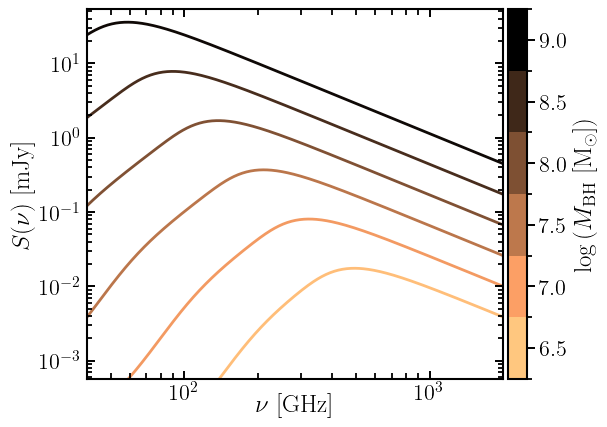

In [8]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")
really_use_same_ylimits = 0
if use_same_ylimits and really_use_same_ylimits:
    ymin, ymax = 1e-2, 2e1
else:
    ymin, ymax = min(S_nu[0]) * 40, 1.5 * max(S_nu[-1])
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(Ms)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of M
for i in range(n):
    plt.plot(
        nu / 1e9, S_nu[i], ls="-", color=colors[i], linewidth=2, label="", zorder=1
    )

ax.loglog()
ax.xaxis.labelpad = -8


if log_M:
    cbar = fig.colorbar(
        sm,
        ticks=co,
        label=r"$\log{(M_\mathrm{BH}~[\mathrm{M}_\odot])}$",
        pad=0.01,
        ax=plt.gca(),
    )
    Ms_labels = ["{:.1f}".format(logM) for logM in log_Ms]
else:
    cbar = fig.colorbar(
        sm, ticks=co, label=r"$M_\mathrm{BH}$ [M$_\odot$]", pad=0.01, ax=plt.gca()
    )
    Ms_labels = ["{:.1f}".format(M / M_sun) for M in Ms]

cbar.ax.set_yticklabels(Ms_labels)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.show()
fig.savefig("corona_seds_M.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $\epsilon_B$

In [9]:
# System parameters
dil = params["dil"]
tau_T = params["tau_T"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
M = params["M"]
delta = params["delta"]
p = params["p"]
eta_g = params["eta_g"]

R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius
n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021

# Parameter to explore
log_beta = 1
if log_beta:
    if use_same_n:
        log_betas = np.linspace(-2.5, 0, 6)  # plasma eps_B values
    else:
        log_betas = np.linspace(-3, 0, 7)  # plasma eps_B values
    betas = 10**log_betas
else:
    betas = np.geomspace(1e-2, 10, 7)  # plasma eps_B values

nu_min, nu_max = 4e10, 2e12
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu_epsB = []
for eps_B in betas:
    U_mag = eps_B * U_th
    B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

    gmax_cool = calc_gmax_cool(eta_g, r_c, B)
    gmax_conf = calc_gmax_conf(R_c, B)
    gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
    nuc_max = (
        4.22e6 * B * gmax_nt**2
    )  # Maximum critical frequency of synchrotron photons

    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu_epsB.append(
        [L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

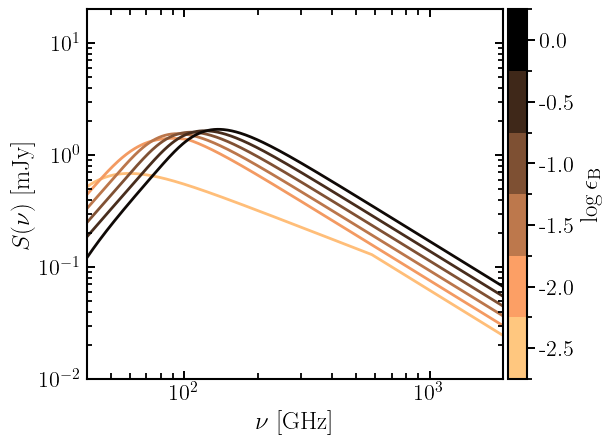

In [10]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")
if use_same_ylimits:
    ymin, ymax = 1e-2, 2e1
else:
    ymin, ymax = min(S_nu_epsB[0]), 2 * max(S_nu_epsB[-1])
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(betas)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of eps_B
for i in range(n):
    plt.plot(
        nu / 1e9, S_nu_epsB[i], ls="-", color=colors[i], linewidth=2, label="", zorder=1
    )

ax.loglog()

if log_beta:
    cbar = fig.colorbar(
        sm, ticks=co, label=r"$\log{\epsilon_\mathrm{B}}$", pad=0.01, ax=plt.gca()
    )
    betas_labels = ["{:.1f}".format(log_eps_B) for log_eps_B in log_betas]
else:
    cbar = fig.colorbar(
        sm, ticks=co, label=r"$\epsilon_\mathrm{B}$", pad=0.01, ax=plt.gca()
    )
    betas_labels = ["{:.2f}".format(eps_B) for eps_B in betas]

cbar.ax.set_yticklabels(betas_labels)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.show()
fig.savefig("corona_seds_epsB.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $\tau$

In [11]:
# System parameters
dil = params["dil"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
M = params["M"]
delta = params["delta"]
eps_B = params["eps_B"]
p = params["p"]
eta_g = params["eta_g"]

R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius
t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale

# Parameter to explore
taus = np.geomspace(0.1, 3.0, 6)  # Opacities

nu_min, nu_max = 4e10, 2e12
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu_tauT = []
for tau_T in taus:
    n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
    U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
    U_mag = eps_B * U_th
    B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

    gmax_cool = calc_gmax_cool(eta_g, r_c, B)
    gmax_conf = calc_gmax_conf(R_c, B)
    gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
    nuc_max = (
        4.22e6 * B * gmax_nt**2
    )  # Maximum critical frequency of synchrotron photons

    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu_tauT.append(
        [L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

    nu_RT = 20 * n_th0 / B  # Razin-Tsytovitch frequency
    print(f"{n_th0 = :.1e}")
    print(f"{B = :.1e}")
    print(f"{nu_RT = :.1e}\n")

n_th0 = 7.2e+07
B = 3.0e+01
nu_RT = 4.7e+07

n_th0 = 1.4e+08
B = 4.3e+01
nu_RT = 6.6e+07

n_th0 = 2.8e+08
B = 6.0e+01
nu_RT = 9.3e+07

n_th0 = 5.5e+08
B = 8.4e+01
nu_RT = 1.3e+08

n_th0 = 1.1e+09
B = 1.2e+02
nu_RT = 1.8e+08

n_th0 = 2.1e+09
B = 1.7e+02
nu_RT = 2.6e+08



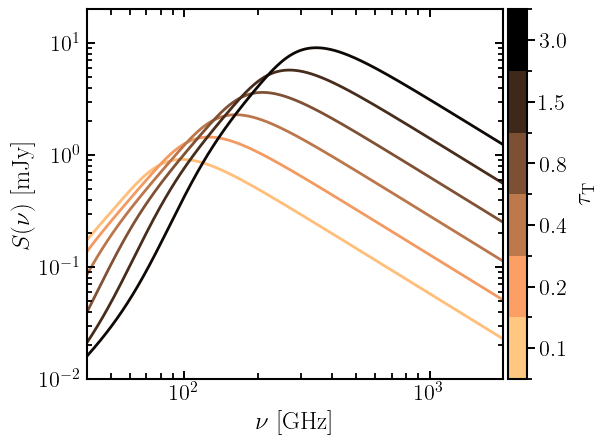

In [12]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")
if use_same_ylimits:
    ymin, ymax = 1e-2, 2e1
else:
    ymin, ymax = min(S_nu_tauT[0]), 2 * max(S_nu_tauT[-1])
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(taus)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of tau_T
for i in range(n):
    plt.plot(
        nu / 1e9, S_nu_tauT[i], ls="-", color=colors[i], linewidth=2, label="", zorder=1
    )

ax.loglog()

cbar = fig.colorbar(sm, ticks=co, label=r"$\tau_\mathrm{T}$", pad=0.01, ax=plt.gca())
taus_labels = ["{:.1f}".format(tau_T) for tau_T in taus]
cbar.ax.set_yticklabels(taus_labels)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.show()
fig.savefig("corona_seds_tauT.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $T$

In [13]:
# System parameters
dil = params["dil"]
tau_T = params["tau_T"]
r_c = params["r_c"]
M = params["M"]
delta = params["delta"]
eps_B = params["eps_B"]
p = params["p"]
eta_g = params["eta_g"]

R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius
n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale

# Parameter to explore
use_kT = 1
if use_kT:
    kTs = np.geomspace(
        15, 300, 6
    )  # Temperatures (theta_e=1 for T~6e9 K); T > 1e10 K is likely unphysical due to runaway pair-production not included in the model
    Ts = kTs * keV / k_B
else:
    Ts = np.linspace(
        3e8, 1e10, 7
    )  # Temperatures (theta_e=1 for T~6e9 K); T > 1e10 K is likely unphysical due to runaway pair-production not included in the model

nu_min, nu_max = 4e10, 2e12
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu_T = []
for T in Ts:
    theta_e = (k_B * T) / mec2  # Normalized temperature
    U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
    U_mag = eps_B * U_th
    B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

    gmax_cool = calc_gmax_cool(eta_g, r_c, B)
    gmax_conf = calc_gmax_conf(R_c, B)
    gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
    nuc_max = (
        4.22e6 * B * gmax_nt**2
    )  # Maximum critical frequency of synchrotron photons

    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu_T.append(
        [L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

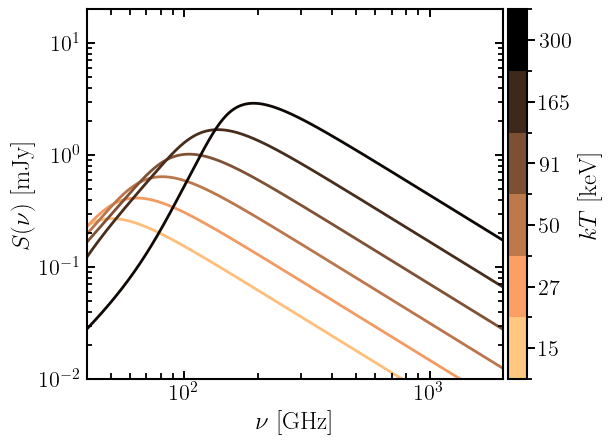

In [14]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")
if use_same_ylimits:
    ymin, ymax = 1e-2, 2e1
else:
    ymin, ymax = min(S_nu_T[0]), 2 * max(S_nu_T[-1])
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(Ts)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of T
for i in range(n):
    plt.plot(
        nu / 1e9, S_nu_T[i], ls="-", color=colors[i], linewidth=2, label="", zorder=1
    )

ax.loglog()

if use_kT:
    cbar = fig.colorbar(sm, ticks=co, label=r"$kT$ [keV]", pad=0.01, ax=plt.gca())
    Ts_labels = ["{:.0f}".format(kT) for kT in kTs]
else:
    cbar = fig.colorbar(sm, ticks=co, label=r"$T$ [K]", pad=0.01, ax=plt.gca())
    Ts_labels = ["{:.1e}".format(T) for T in Ts]

cbar.ax.set_yticklabels(Ts_labels)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.show()
fig.savefig("corona_seds_T.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $T$ - forcing the thermal component

In [15]:
# System parameters
dil = params["dil"]
tau_T = params["tau_T"]
r_c = params["r_c"]
M = params["M"]
delta = 0.001
eps_B = params["eps_B"]
p = params["p"]
eta_g = params["eta_g"]

R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius
n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale

# Parameter to explore
kTs = np.linspace(200, 400, 3)
Ts = kTs * keV / k_B

nu_min, nu_max = 3e10, 2e12
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu = []
S_nu_th = []
for T in Ts:
    theta_e = (k_B * T) / mec2  # Normalized temperature
    U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
    U_mag = eps_B * U_th
    B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

    gmax_cool = calc_gmax_cool(eta_g, r_c, B)
    gmax_conf = calc_gmax_conf(R_c, B)
    gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
    nuc_max = (
        4.22e6 * B * gmax_nt**2
    )  # Maximum critical frequency of synchrotron photons

    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu.append([L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))])

    L_i_th = Lnu_fun(
        nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=1e-6, p=p
    )
    S_nu_th.append(
        [L_i_th[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

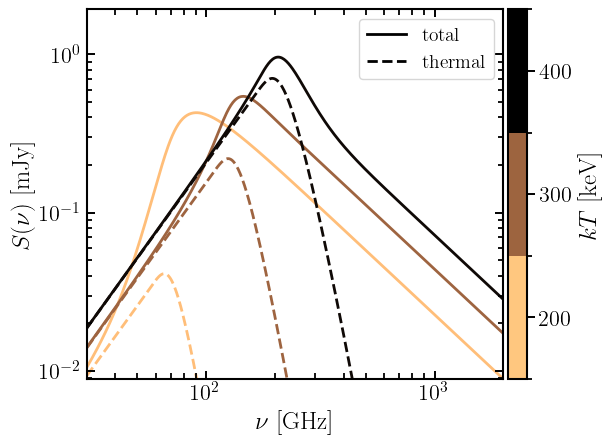

In [16]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")
if use_same_ylimits:
    ymin, ymax = min(S_nu[0]), 2 * max(S_nu[-1])
else:
    ymin, ymax = min(S_nu[0]), 2 * max(S_nu[-1])
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(Ts)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of T
for i in range(n):
    plt.plot(
        nu / 1e9, S_nu[i], ls="-", color=colors[i], linewidth=2, label="", zorder=1
    )
    plt.plot(
        nu / 1e9, S_nu_th[i], ls="--", color=colors[i], linewidth=2, label="", zorder=1
    )

# Add two dummy plots for the legend
plt.plot([], [], ls="-", color="k", linewidth=2, label="total")
plt.plot([], [], ls="--", color="k", linewidth=2, label="thermal")

ax.loglog()

if use_kT:
    cbar = fig.colorbar(sm, ticks=co, label=r"$kT$ [keV]", pad=0.01, ax=plt.gca())
    labels = ["{:.0f}".format(kT) for kT in kTs]
else:
    cbar = fig.colorbar(sm, ticks=co, label=r"$T$ [K]", pad=0.01, ax=plt.gca())

    labels = ["{:.1e}".format(T) for T in Ts]
cbar.ax.set_yticklabels(labels)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.legend(loc="best")
plt.show()
fig.savefig("corona_seds_T_thermal.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $\tau$ using the $T$ from the correlation

In [17]:
# System parameters
dil = params["dil"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
M = params["M"]
delta = params["delta"]
eps_B = params["eps_B"]
p = params["p"]
eta_g = params["eta_g"]

R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius


# Parameter to explore
def fit_par(x):
    """The observed correlation by Tortosa+2018 for a spherical geometry
    log10(kT) = a * log10(tau) + b
    Input:
    x: log10(tau)"""
    a = ufloat(-0.7, 0.2)
    b = ufloat(1.8, 0.1)
    return a * x + b


taus = np.geomspace(0.1, 3, 6)  # Opacities
log10_kT = fit_par(np.log10(taus))
kTs = np.power(
    10, [value.n for value in log10_kT]
)  # Extract nominal values and apply 10^x function
Ts = kTs * keV / k_B

nu_min, nu_max = 4e10, 2e12
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu_tauT_T = []
for tau_T, T in zip(taus, Ts):
    n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
    theta_e = (k_B * T) / mec2  # Normalized temperature
    U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
    U_mag = eps_B * U_th
    B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

    gmax_cool = calc_gmax_cool(eta_g, r_c, B)
    gmax_conf = calc_gmax_conf(R_c, B)
    gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
    nuc_max = (
        4.22e6 * B * gmax_nt**2
    )  # Maximum critical frequency of synchrotron photons

    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu_tauT_T.append(
        [L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

    kT = T * k_B / keV
    print(f"{tau_T = :.1e}, {kT = :.1e} keV")

tau_T = 1.0e-01, kT = 3.2e+02 keV
tau_T = 2.0e-01, kT = 2.0e+02 keV
tau_T = 3.9e-01, kT = 1.2e+02 keV
tau_T = 7.7e-01, kT = 7.6e+01 keV
tau_T = 1.5e+00, kT = 4.7e+01 keV
tau_T = 3.0e+00, kT = 2.9e+01 keV


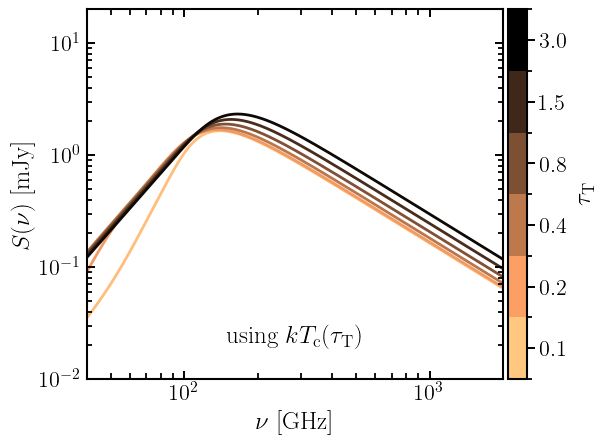

In [18]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")
if use_same_ylimits:
    ymin, ymax = 1e-2, 2e1
else:
    ymin, ymax = min(S_nu_tauT_T[0]), 2 * max(S_nu_tauT_T[-1])
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(taus)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of tau_T
for i in range(n):
    plt.plot(
        nu / 1e9,
        S_nu_tauT_T[i],
        ls="-",
        color=colors[i],
        linewidth=2,
        label="",
        zorder=1,
    )

fig.text(
    0.45,
    0.2,
    r"using $kT_\mathrm{c}(\tau_\mathrm{T})$",
    ha="center",
    va="center",
    fontsize=nice_fonts["axes.labelsize"],
)

ax.loglog()

cbar = fig.colorbar(sm, ticks=co, label=r"$\tau_\mathrm{T}$", pad=0.01, ax=plt.gca())
taus_labels2 = ["{:.1f}".format(tau_T) for tau_T in taus]
cbar.ax.set_yticklabels(taus_labels2)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.show()
fig.savefig("corona_seds_tauT_correl-T.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $p$

In [19]:
# System parameters
dil = params["dil"]
tau_T = params["tau_T"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
M = params["M"]
delta = params["delta"]
eps_B = params["eps_B"]
eta_g = params["eta_g"]

R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius
n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
U_mag = eps_B * U_th
B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

# NT electrons
gmax_cool = calc_gmax_cool(eta_g, r_c, B)
gmax_conf = calc_gmax_conf(R_c, B)
gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
nuc_max = 4.22e6 * B * gmax_nt**2  # Maximum critical frequency of synchrotron photons

# Parameter to explore
ps = np.linspace(2.2, 3.0, 6)  # Temperatures (theta_e=1 for T~6e9 K)

nu_min, nu_max = 4e10, 2e12
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu_p = []
for p in ps:
    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu_p.append(
        [L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

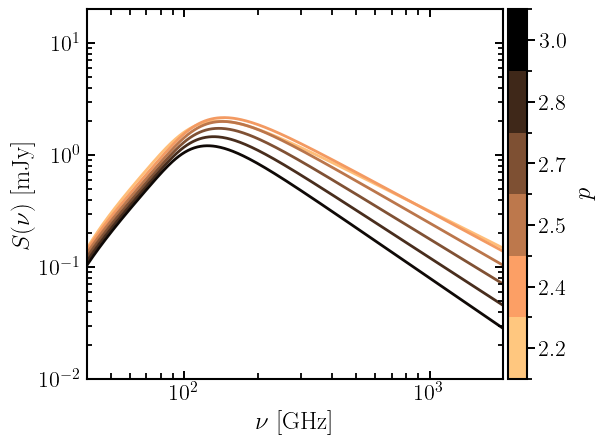

In [20]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")

if use_same_ylimits:
    ymin, ymax = 1e-2, 2e1
else:
    ymin, ymax = min(S_nu_p[0]), 2 * max_p(S_nu[0])
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(ps)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of p
for i in range(n):
    plt.plot(
        nu / 1e9, S_nu_p[i], ls="-", color=colors[i], linewidth=2, label="", zorder=1
    )

ax.loglog()

cbar = fig.colorbar(sm, ticks=co, label=r"$p$", pad=0.01, ax=plt.gca())

ps_labels = ["{:.1f}".format(p) for p in ps]
cbar.ax.set_yticklabels(ps_labels)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.show()
fig.savefig("corona_seds_p.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $r_\mathrm{c}$

In [21]:
# System parameters
dil = params["dil"]
tau_T = params["tau_T"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
M = params["M"]
delta = params["delta"]
eps_B = params["eps_B"]
p = params["p"]
eta_g = params["eta_g"]

R_g = 1.5e5 * (M / M_sun)  # Gravitational radius

# Parameter to explore
rcs = np.geomspace(20, 350, 6)  # R_c/R_g

nu_min, nu_max = 4e10, 2e12
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu_rc = []
for r_c in rcs:
    R_c = r_c * R_g  # Coronal radius
    n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
    t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
    U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
    U_mag = eps_B * U_th
    B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

    gmax_cool = calc_gmax_cool(eta_g, r_c, B)
    gmax_conf = calc_gmax_conf(R_c, B)
    gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
    nuc_max = (
        4.22e6 * B * gmax_nt**2
    )  # Maximum critical frequency of synchrotron photons

    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu_rc.append(
        [L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

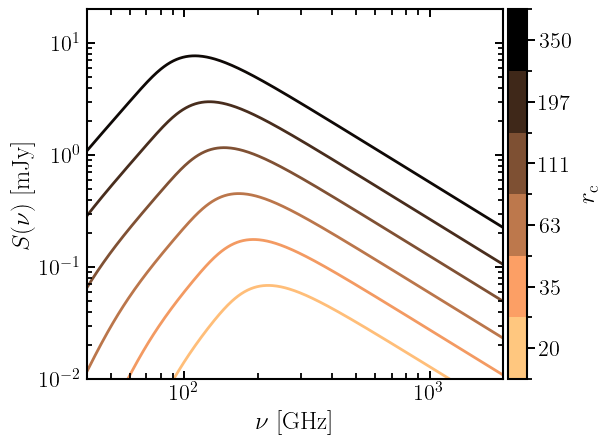

In [22]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")  # For fluxes
if use_same_ylimits:
    ymin, ymax = 1e-2, 2e1  # For fluxes
else:
    ymin, ymax = min(S_nu_rc[0]), 2 * max(S_nu_rc[-1])  # For fluxes
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(rcs)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of r_c
for i in range(n):
    plt.plot(
        nu / 1e9, S_nu_rc[i], ls="-", color=colors[i], linewidth=2, label="", zorder=1
    )

ax.loglog()

cbar = fig.colorbar(sm, ticks=co, label=r"$r_\mathrm{c}$", pad=0.01, ax=plt.gca())

rcs_labels = ["{:.0f}".format(r_c) for r_c in rcs]
cbar.ax.set_yticklabels(rcs_labels)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.show()
fig.savefig("corona_seds_rc.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $\delta$

In [23]:
# System parameters
dil = params["dil"]
tau_T = params["tau_T"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
M = params["M"]
eps_B = params["eps_B"]
p = params["p"]
eta_g = params["eta_g"]

R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius
n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
U_mag = eps_B * U_th
B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

# NT electrons
gmax_cool = calc_gmax_cool(eta_g, r_c, B)
gmax_conf = calc_gmax_conf(R_c, B)
gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
nuc_max = 4.22e6 * B * gmax_nt**2  # Maximum critical frequency of synchrotron photons

# Parameter to explore
log_delta = 1
if log_delta:
    if use_same_n:
        log_deltas = np.linspace(-3, -0.5, 6)
    else:
        log_deltas = np.linspace(-3, -1, 5)

    deltas = 10**log_deltas
else:
    deltas = np.geomspace(0.01, 0.5, 6)  # Temperatures (theta_e=1 for T~6e9 K)

nu_min, nu_max = 4e10, 2e12
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu_delta = []
for delta in deltas:
    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu_delta.append(
        [L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

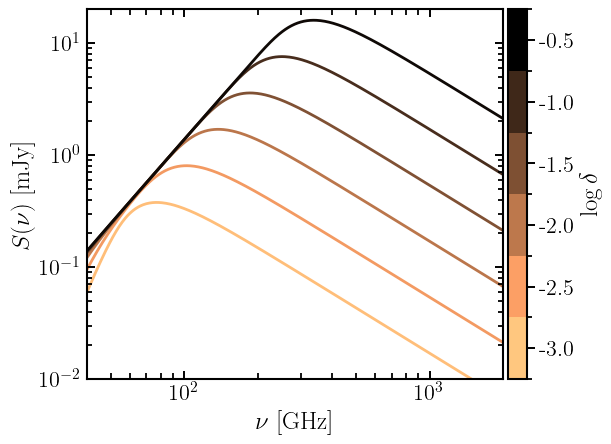

In [24]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")

if use_same_ylimits:
    ymin, ymax = 1e-2, 2e1
else:
    ymin, ymax = min(S_nu_delta[0]), 2 * max(S_nu_delta[-1])
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(deltas)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of delta
for i in range(n):
    plt.plot(
        nu / 1e9,
        S_nu_delta[i],
        ls="-",
        color=colors[i],
        linewidth=2,
        label="",
        zorder=1,
    )

ax.loglog()

if log_delta:
    cbar = fig.colorbar(sm, ticks=co, label=r"$\log \delta$", pad=0.01, ax=plt.gca())
    deltas_labels = ["{:.1f}".format(logdelta) for logdelta in log_deltas]
else:
    cbar = fig.colorbar(sm, ticks=co, label=r"$\delta$", pad=0.01, ax=plt.gca())
    deltas_labels = ["{:.2f}".format(delta) for delta in deltas]
cbar.ax.set_yticklabels(deltas_labels)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.show()
fig.savefig("corona_seds_delta.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $\delta$ while fixing $\epsilon_B$ using an energy condition

In [25]:
# System parameters
dil = params["dil"]
M = params["M"]
tau_T = params["tau_T"]
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
eps_B = params["eps_B"]
p = params["p"]
eta_g = params["eta_g"]

R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius
n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale
U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021

# For fixing the magnetic field
eta_mag = 1.0
xi_ep = 40.0

# Parameter to explore
log_delta = 1
if log_delta:
    if use_same_n:
        log_deltas = np.linspace(-3, -0.5, 6)
    else:
        log_deltas = np.linspace(-3, -1, 5)

    deltas = 10**log_deltas
else:
    deltas = np.geomspace(0.01, 0.5, 6)  # Temperatures (theta_e=1 for T~6e9 K)

nu_min, nu_max = 4e10, 2e12
nu = np.geomspace(nu_min, nu_max, 400)

L_nu = []
L_nu_corr = []
S_nu_eps_delta = []
for delta in deltas:
    eps_B = eta_mag * delta * (1 + xi_ep)
    U_mag = eps_B * U_th
    B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G
    gmax_cool = calc_gmax_cool(eta_g, r_c, B)
    gmax_conf = calc_gmax_conf(R_c, B)
    gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor

    L_i = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    L_nu.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu_eps_delta.append(
        [L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

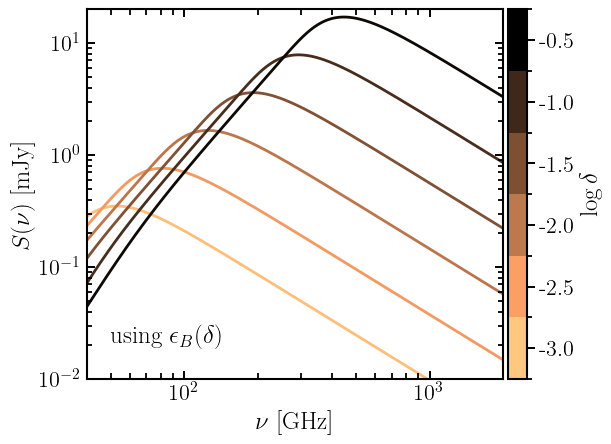

In [26]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")

if use_same_ylimits:
    ymin, ymax = 1e-2, 2e1
else:
    ymin, ymax = min(S_nu_eps_delta[0]), 2 * max(S_nu_eps_delta[-1])
plt.xlim(nu_min / 1e9, nu_max / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(deltas)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of delta
for i in range(n):
    plt.plot(
        nu / 1e9,
        S_nu_eps_delta[i],
        ls="-",
        color=colors[i],
        linewidth=2,
        label="",
        zorder=1,
    )

ax.loglog()

if log_delta:
    cbar = fig.colorbar(sm, ticks=co, label=r"$\log \delta$", pad=0.01, ax=plt.gca())
    deltas_labels2 = ["{:.1f}".format(logdelta) for logdelta in log_deltas]
else:
    cbar = fig.colorbar(sm, ticks=co, label=r"$\delta$", pad=0.01, ax=plt.gca())
    deltas_labels2 = ["{:.2f}".format(delta) for delta in deltas]
cbar.ax.set_yticklabels(deltas_labels2)  # vertically oriented colorbar
ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

fig.text(
    0.25,
    0.2,
    r"using $\epsilon_B(\delta)$",
    ha="center",
    va="center",
    fontsize=nice_fonts["axes.labelsize"],
)

plt.show()
fig.savefig("corona_seds_delta_with_E_cond.pdf", bbox_inches="tight", pad_inches=0.01)

## Big 3x2 figure with shared axis

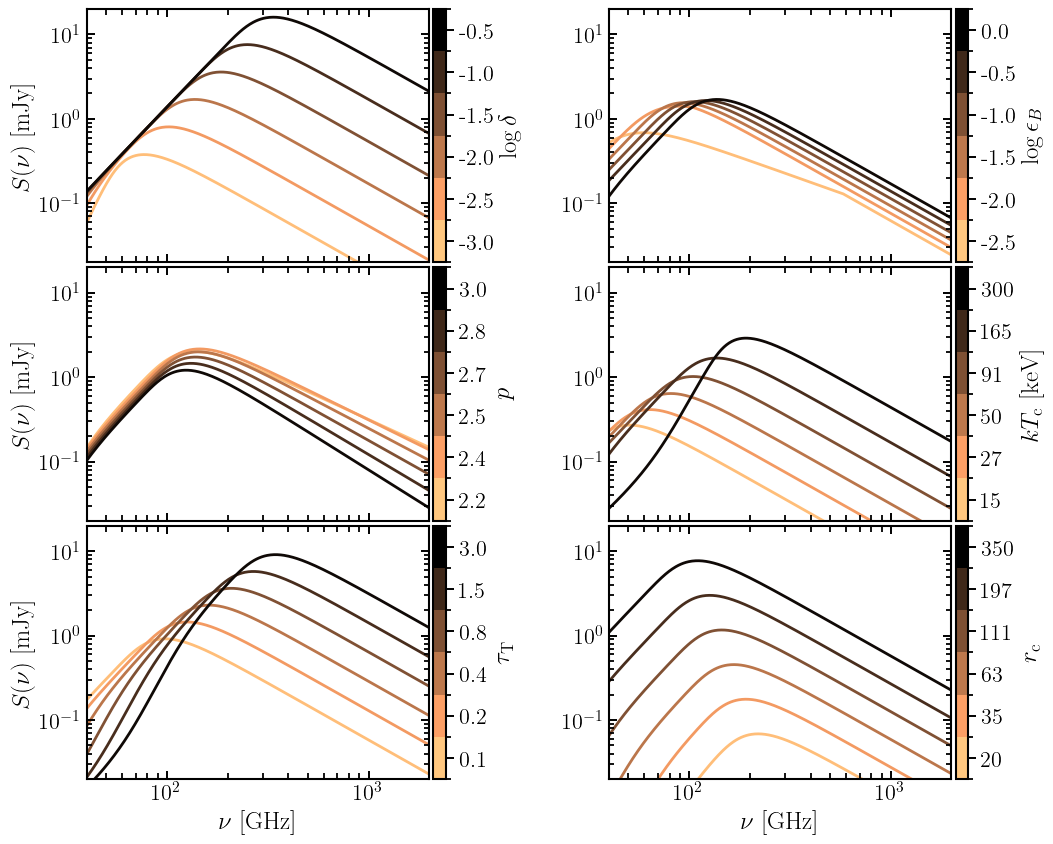

In [27]:
# Define the data and labels for each subplot
data_sets = [
    S_nu_delta,
    S_nu_epsB,
    S_nu_p,
    S_nu_T,
    S_nu_tauT,
    S_nu_rc,
]  # Replace with actual data variables
cbar_labels = [
    r"$\log \delta$",
    r"$\log \epsilon_B$",
    r"$p$",
    r"$kT_\mathrm{c}~\mathrm{[keV]}$",
    r"$\tau_\mathrm{T}$",
    r"$r_\mathrm{c}$",
]
cbar_tics = [deltas_labels, betas_labels, ps_labels, Ts_labels, taus_labels, rcs_labels]

# Create a 2x3 grid of subplots with independent x and y scales
fig, axs = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.02, wspace=0.28)

# Define the colour palette and discrete colour map (same palette for all plots)
n = 6
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Iterate over each subplot to generate independent plots and colour bars
for index, ax in enumerate(axs.flat):
    # Retrieve the specific data set and colour bar label for this subplot
    S_nu = data_sets[index]
    cbar_label = cbar_labels[index]
    cbar_tic = cbar_tics[index]

    # Set labels only on the first column and bottom row
    if index % 2 == 0:
        ax.set_ylabel(r"$S(\nu)$ [mJy]")
    if index >= 4:
        ax.set_xlabel(r"$\nu$ [GHz]")

    # Set x and y limits for consistency across subplots
    ax.set_xlim(nu_min / 1e9, nu_max / 1e9)
    ymin, ymax = (2e-2, 2e1)
    ax.set_ylim(ymin, ymax)

    # Plot data for each line with independent colours
    for i in range(n):
        ax.plot(nu / 1e9, S_nu[i], ls="-", color=colors[i], linewidth=2, zorder=1)

    # Apply log-log scale and tick settings
    ax.loglog()
    ax.tick_params(
        axis="both", which="both", right=True, left=True, top=True, direction="in"
    )

    # Add a colour bar to each subplot with the corresponding label
    cbar = fig.colorbar(sm, ax=ax, ticks=co, label=cbar_label, pad=0.01)
    cbar.ax.set_yticklabels(cbar_tic)

# Save and display the figure
plt.show()
fig.savefig("corona_seds_many-parameters.pdf", bbox_inches="tight", pad_inches=0.01)

### Put together the $\epsilon_B(\delta)$ and $kT(\tau)$ plots

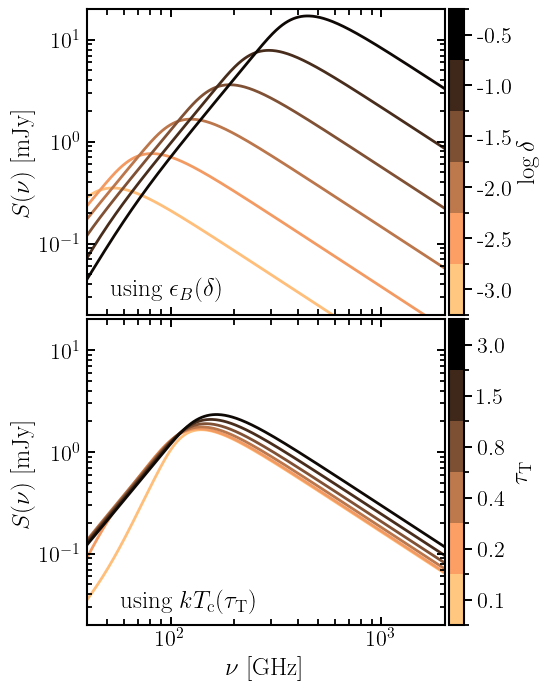

In [28]:
# Define the data and labels for each subplot
data_sets = [S_nu_eps_delta, S_nu_tauT_T]
cbar_labels = [r"$\log \delta$", r"$\tau_\mathrm{T}$"]
cbar_tics = [deltas_labels2, taus_labels2]

# Create a 2x3 grid of subplots with independent x and y scales
fig, axs = plt.subplots(2, 1, figsize=(5.5, 8), sharex=True)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.015)

# Define the colour palette and discrete colour map (same palette for all plots)
n = 6
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Iterate over each subplot to generate independent plots and colour bars
for index, ax in enumerate(axs.flat):
    # Retrieve the specific data set and colour bar label for this subplot
    S_nu = data_sets[index]
    cbar_label = cbar_labels[index]
    cbar_tic = cbar_tics[index]

    # Set labels only on the first column and bottom row
    ax.set_ylabel(r"$S(\nu)$ [mJy]")
    if index == 1:
        ax.set_xlabel(r"$\nu$ [GHz]")

    # Set x and y limits for consistency across subplots
    ax.set_xlim(nu_min / 1e9, nu_max / 1e9)
    ymin, ymax = (2e-2, 2e1)
    ax.set_ylim(ymin, ymax)

    # Plot data for each line with independent colours
    for i in range(n):
        ax.plot(nu / 1e9, S_nu[i], ls="-", color=colors[i], linewidth=2, zorder=1)

    # Apply log-log scale and tick settings
    ax.loglog()
    ax.tick_params(
        axis="both", which="both", right=True, left=True, top=True, direction="in"
    )

    # Add a colour bar to each subplot with the corresponding label
    cbar = fig.colorbar(sm, ax=ax, ticks=co, label=cbar_label, pad=0.01)
    cbar.ax.set_yticklabels(cbar_tic)

    if index == 0:
        fig.text(
            0.31,
            0.14,
            r"using $kT_\mathrm{c}(\tau_\mathrm{T})$",
            ha="center",
            va="center",
            fontsize=nice_fonts["axes.labelsize"],
        )
    elif index == 1:
        fig.text(
            0.27,
            0.53,
            r"using $\epsilon_B(\delta)$",
            ha="center",
            va="center",
            fontsize=nice_fonts["axes.labelsize"],
        )

# Save and display the figure
plt.show()
fig.savefig("corona_seds_fixed-conditions.pdf", bbox_inches="tight", pad_inches=0.01)

## Dependence on $z$
(everything will be fixed, only the distance and frequency shift change with z; focused on SKA detectability)

In [29]:
# System parameters
r_c = params["r_c"]
kT = params["kT"]
T = params["T"]
theta_e = params["theta_e"]
delta = params["delta"]
eps_B = params["eps_B"]
p = params["p"]
eta_g = params["eta_g"]
tau_T = params["tau_T"]

M = 1e9 * M_sun  # BH mass
R_g = 1.5e5 * (M / M_sun)  # Gravitational radius
R_c = r_c * R_g  # Coronal radius
n_th0 = tau_T / (sigma_T * R_c)  # Number density of thermal electrons
t_dyn = t_ff(r_c, M / M_sun)  # Characteristic dynamical timescale

U_th = a_fun(theta_e) * n_th0 * theta_e * mec2  # Eq. 1 from Margalit+2021
U_mag = eps_B * U_th
B = np.sqrt(8 * pi * U_mag)  # Magnetic field in G

gmax_cool = calc_gmax_cool(eta_g, r_c, B)
gmax_conf = calc_gmax_conf(R_c, B)
gmax_nt = min(gmax_cool, gmax_conf)  # Maximum Lorentz factor
nuc_max = 4.22e6 * B * gmax_nt**2  # Maximum critical frequency of synchrotron photons

eta_mag = 1.0
xi_ep = 40.0
eps_B = eta_mag * delta * (1 + xi_ep)

nu_min = 3e9
nu_max = 2e12
nu = np.geomspace(nu_min, nu_max, 250)

# Parameters of the other model components (set to arbitrary values)
tau_eq1_freq = 9.7e2
SYNC_scale = 28.2
FF_scale = 28.7
RJ_scale = 29.5
beta = 2.0

# Add a magnification factor
lens = 10.0

# Parameter to explore
zs = np.linspace(1.0, 4.0, 4)

L_nu = []
L_nu_nocor = []
L_nu_corr = []
S_nu = []
S_nu_nocor = []
cor_nu = []
for z in zs:
    d = (
        Planck18.luminosity_distance(z).value * 1e6 * pc
    )  # source distance (from Mpc to cm)
    dil = 4 * pi * d**2
    cor = Lnu_fun(nu=nu, ne=n_th0, R=R_c, Theta=theta_e, B=B, t=t_dyn, delta=delta, p=p)
    dust = RJ_dust(nu, lg_scaling_rj=RJ_scale, nu_tau1_rest=tau_eq1_freq, beta=2.1, z=z)
    ff = pl_emission(nu, lg_scaling=FF_scale, alpha=-0.1, z=z)
    sy = pl_emission(nu, lg_scaling=SYNC_scale, alpha=-1.0, z=z)
    L_i = cor + dust + ff + sy
    L_i_nocor = dust + ff + sy

    L_nu.append(L_i)
    L_nu_nocor.append(L_i)
    L_nu_corr.append([L_i[i] * np.exp(-nu[i] / nuc_max) for i in range(len(nu))])
    S_nu.append(
        [lens * L_i[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )
    S_nu_nocor.append(
        [
            lens * L_i_nocor[i] * np.exp(-nu[i] / nuc_max) / dil / mJy
            for i in range(len(nu))
        ]
    )
    cor_nu.append(
        [lens * cor[i] * np.exp(-nu[i] / nuc_max) / dil / mJy for i in range(len(nu))]
    )

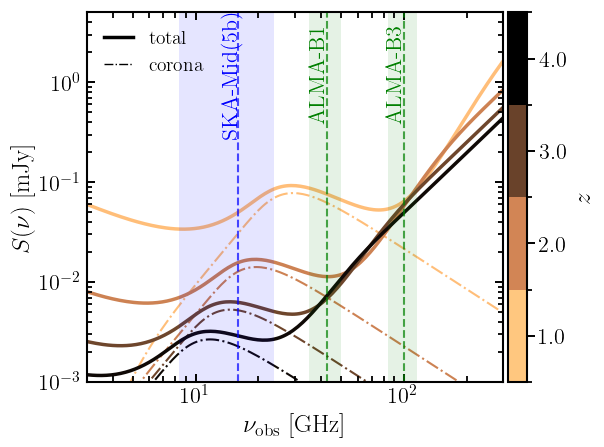

In [30]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title("")
plt.setp(ax, xlabel=r"$\nu_\mathrm{obs}$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")
ymin, ymax = 0.1e-2, 5.0
plt.xlim(nu_min / 1e9, 3e11 / 1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
n = len(zs)
color_vector = np.linspace(0.05, 0.95, n)
colors = plt.cm.copper_r(color_vector)

# Generate a discrete colorbar for "n" points
co = np.arange(1, n + 1)
cmap = matplotlib.colormaps["copper_r"].resampled(n)
norm = matplotlib.colors.BoundaryNorm(np.arange(n + 1) + 0.5, n)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Create some sample lines
line1 = Line2D([0], [0], color="black", linestyle="-", linewidth=2.5, label="total")
line3 = Line2D([0], [0], color="black", linestyle="-.", linewidth=1, label="corona")

# Create a list of handles and labels for the legend
handles = [line1, line3]
labels = [line1.get_label(), line3.get_label()]

# Plot for each value of M
for i in range(n):
    plt.plot(
        nu / 1e9 / (1 + zs[i]),
        S_nu[i],
        ls="-",
        color=colors[i],
        linewidth=2.5,
        label="",
        zorder=1,
    )
    plt.plot(
        nu / 1e9 / (1 + zs[i]),
        cor_nu[i],
        ls="-.",
        color=colors[i],
        linewidth=1.5,
        alpha=1,
        label="",
        zorder=0,
    )


# Add the custom legend box
plt.legend(handles, labels, loc="best", fontsize=14, handlelength=1.5, frameon=False)

ax.loglog()

cbar = fig.colorbar(sm, ticks=co, label=r"$z$", pad=0.01, ax=plt.gca())

zs_labels = ["{:.1f}".format(z) for z in zs]
cbar.ax.set_yticklabels(zs_labels)  # vertically oriented colorbar

# Add a rectangle showing the ALMA spectral bands
bands_to_plot = ["SKA-Mid(5b)", "ALMA-B1", "ALMA-B3"]
band_colors = ["blue", "green", "green"]
y_positions = [0.24 * ymax for i in bands_to_plot]
plot_bands(ax, ymin, ymax, bands_to_plot, y_positions=y_positions, colors=band_colors)

ax.tick_params(
    axis="both", which="both", right=True, left=True, top=True, direction="in"
)

plt.show()
fig.savefig("corona_seds_z_M1e9_SKA.pdf", bbox_inches="tight", pad_inches=0.001)